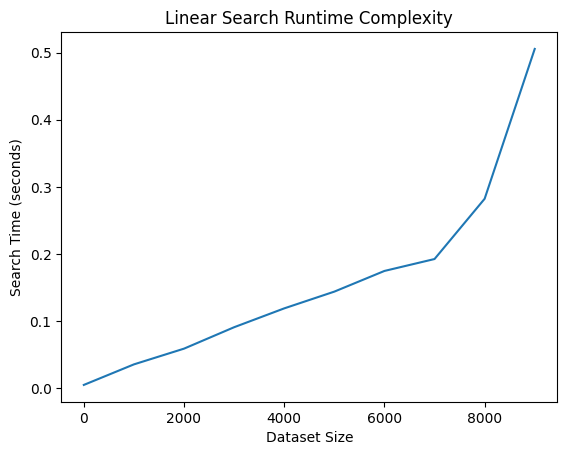

In [6]:
import time

def linear_search(dataset, username):
    for item in dataset:
        if item == username:
            return True
    return False

# Example of timing linear search
search_times = []
for i in range(1, num_usernames + 1, num_usernames // 10): # Varying dataset size
    subset = dataset[:i]
    start_time = time.time()
    for _ in range(10000):  # Perform 10,000 lookups
        linear_search(subset, generate_random_username())
    end_time = time.time()
    search_times.append(end_time - start_time)

# Plot the results
import matplotlib.pyplot as plt

plt.plot(range(1, num_usernames + 1, num_usernames // 10), search_times)
plt.xlabel("Dataset Size")
plt.ylabel("Search Time (seconds)")
plt.title("Linear Search Runtime Complexity")
plt.show()

In [57]:
import time
import random

def timing_decorator(func):
    """
    Decorator to measure the execution time of a function.
    """
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time  # Calculate elapsed time
        print(f"{func.__name__} took {elapsed_time:.4f} seconds")
        return elapsed_time  # Return the elapsed time
    return wrapper

def simple_hash(s, m):
    """
    A very basic hash function for demonstration.

    Args:
        s (str): The string to hash.
        m (int): The size of the hash table or bit array.

    Returns:
        int: The hash value (an index between 0 and m-1).
    """
    hash_val = 0
    for char in s:
        hash_val = (hash_val * 31 + ord(char)) % m  # Using a prime multiplier
    return hash_val

def mmh3_hash(s, m, seed=0):
    """
    A basic implementation of MurmurHash3 (32-bit version) for demonstration.

    Args:
        s (str): The string to hash.
        m (int): The size of the hash table or bit array.
        seed (int): Seed for the hash function

    Returns:
        int: The hash value (an index between 0 and m-1).
    """
    def fmix32(h):
        h ^= h >> 16
        h = (h * 0x85ebca6b) & 0xFFFFFFFF
        h ^= h >> 13
        h = (h * 0xc2b2ae35) & 0xFFFFFFFF
        h ^= h >> 16
        return h

    length = len(s)
    n_blocks = int(length / 4)

    h1 = seed

    c1 = 0xcc9e2d51
    c2 = 0x1b873593

    # body
    for block_start in range(0, n_blocks * 4, 4):
        # little endian
        k1 = ord(s[block_start + 3]) << 24 | \
            ord(s[block_start + 2]) << 16 | \
            ord(s[block_start + 1]) << 8 | \
            ord(s[block_start + 0])

        k1 = (c1 * k1) & 0xFFFFFFFF
        k1 = (k1 << 15 | k1 >> 17) & 0xFFFFFFFF  # inlined ROTL32
        k1 = (c2 * k1) & 0xFFFFFFFF

        h1 ^= k1
        h1 = (h1 << 13 | h1 >> 19) & 0xFFFFFFFF  # inlined ROTL32
        h1 = (h1 * 5 + 0xe6546b64) & 0xFFFFFFFF

    # tail
    tail_index = n_blocks * 4
    k1 = 0
    tail_size = length & 3

    if tail_size >= 3:
        k1 ^= ord(s[tail_index + 2]) << 16
    if tail_size >= 2:
        k1 ^= ord(s[tail_index + 1]) << 8
    if tail_size >= 1:
        k1 ^= ord(s[tail_index + 0])

    if tail_size > 0:
        k1 = (k1 * c1) & 0xFFFFFFFF
        k1 = (k1 << 15 | k1 >> 17) & 0xFFFFFFFF  # inlined ROTL32
        k1 = (k1 * c2) & 0xFFFFFFFF
        h1 ^= k1

    # finalization
    unsigned_val = fmix32(h1 ^ length)
    return unsigned_val % m

In [58]:
#from src.utils import simple_hash, mmh3_hash
import math
import random

class LoginChecker:
    def __init__(self, dataset=None, capacity=None, error_rate=0.001):
        """
        Initializes data structures for login checking algorithms.

        Args:
            dataset (list, optional): Pre-existing dataset of usernames. Defaults to None.
            capacity (int, optional): Estimated capacity for Bloom/Cuckoo filters. Defaults to None.
            error_rate (float, optional): Desired error rate for Bloom filter. Defaults to 0.001.
        """
        if dataset:
            self.dataset = dataset
            self.dataset_set = set(dataset)  # For hashing
            self.dataset.sort()  # For binary search

            # Bloom filter parameters
            self.capacity = len(dataset)
            self.error_rate = error_rate

            # Corrected the order here:
            self.bit_array_size = self._calculate_bit_array_size() # Calculate bit array size first
            self.num_hashes = self._calculate_num_hashes() # Then calculate the number of hashes

            self.bit_array = [0] * self.bit_array_size

            # Cuckoo filter parameters
            self.bucket_size = 4
            self.fingerprint_size = 2  # Adjust as needed
            self.max_displacements = 500 # Max kickout
            self.cuckoo_table = [([None] * self.bucket_size) for _ in range(self.capacity)]

            # Populate filters using the dataset
            for item in dataset:
                self._add_to_bloom_filter(item)
                self._insert_to_cuckoo_filter(item)
        else:
            self.dataset = []
            self.dataset_set = set()

            # Initialize filters with capacity and error_rate
            self.capacity = capacity
            self.error_rate = error_rate

            # Corrected the order here:
            self.bit_array_size = self._calculate_bit_array_size()
            self.num_hashes = self._calculate_num_hashes()

            self.bit_array = [0] * self.bit_array_size

            self.bucket_size = 4
            self.fingerprint_size = 2
            self.max_displacements = 500
            self.cuckoo_table = [([None] * self.bucket_size) for _ in range(self.capacity)]

    def linear_search(self, username):
        """
        Checks if a username exists using linear search.

        Args:
            username (str): The username to check.

        Returns:
            bool: True if the username exists, False otherwise.
        """
        for item in self.dataset:
            if item == username:
                return True
        return False

    def binary_search(self, username):
        """
        Checks if a username exists using binary search.

        Args:
            username (str): The username to check.

        Returns:
            bool: True if the username exists, False otherwise.
        """
        low = 0
        high = len(self.dataset) - 1
        while low <= high:
            mid = (low + high) // 2
            if self.dataset[mid] == username:
                return True
            elif self.dataset[mid] < username:
                low = mid + 1
            else:
                high = mid - 1
        return False

    def hash_search(self, username):
        """
        Checks if a username exists using a hash set.

        Args:
            username (str): The username to check.

        Returns:
            bool: True if the username exists, False otherwise.
        """
        return username in self.dataset_set

    def _calculate_bit_array_size(self):
        """
        Calculates the optimal size of the bit array for a Bloom filter.

        Returns:
            int: The size of the bit array.
        """
        m = - (self.capacity * math.log(self.error_rate)) / (math.log(2) ** 2)
        return int(m)

    def _calculate_num_hashes(self):
        """
        Calculates the optimal number of hash functions for a Bloom filter.

        Returns:
            int: The number of hash functions.
        """
        k = (self.bit_array_size / self.capacity) * math.log(2)
        return int(k)

    def _add_to_bloom_filter(self, username):
        """
        Adds a username to the Bloom filter.

        Args:
            username (str): The username to add.
        """
        for i in range(self.num_hashes):
            index = mmh3_hash(username, self.bit_array_size, seed=i)
            self.bit_array[index] = 1

    def bloom_filter_check(self, username):
        """
        Checks if a username might exist in the Bloom filter.

        Args:
            username (str): The username to check.

        Returns:
            bool: True if the username might exist, False if it definitely does not.
        """
        for i in range(self.num_hashes):
            index = mmh3_hash(username, self.bit_array_size, seed=i)
            if self.bit_array[index] == 0:
                return False
        return True

    def _get_fingerprint(self, item):
        """
        Generates a fingerprint for an item.

        Args:
            item (str): The item for which to generate a fingerprint.

        Returns:
            int: The fingerprint of the item.
        """
        hash_value = mmh3_hash(item, 2**(self.fingerprint_size * 8))
        return hash_value & ((1 << (self.fingerprint_size * 8)) - 1)

    def _insert_to_cuckoo_filter(self, item):
        """
        Inserts an item into the Cuckoo filter.

        Args:
            item (str): The item to insert.
        """
        f = self._get_fingerprint(item)
        i1 = simple_hash(item, self.capacity)
        i2 = (i1 ^ simple_hash(str(f), self.capacity)) % self.capacity

        for _ in range(self.max_displacements):
            for index in [i1, i2]:
                if 0 <= index < len(self.cuckoo_table):  # Check index bounds
                    for j in range(self.bucket_size):
                        if self.cuckoo_table[index][j] is None:
                            self.cuckoo_table[index][j] = f
                            return

            # If no empty slot, randomly kick out an item
            index = random.choice([i1, i2])
            if 0 <= index < len(self.cuckoo_table):  # Check index bounds
                j = random.randrange(self.bucket_size)
                f, self.cuckoo_table[index][j] = self.cuckoo_table[index][j], f
                i1 = index
                i2 = (i1 ^ simple_hash(str(f), self.capacity)) % self.capacity

        # If max displacements reached, filter is considered full
        raise Exception("Cuckoo filter is full")

    def cuckoo_filter_check(self, item):
        """
        Checks if an item might exist in the Cuckoo filter.

        Args:
            item (str): The item to check.

        Returns:
            bool: True if the item might exist, False if it definitely does not.
        """
        f = self._get_fingerprint(item)
        i1 = simple_hash(item, self.capacity)
        i2 = (i1 ^ simple_hash(str(f), self.capacity)) % self.capacity

        for index in [i1, i2]:
            if 0 <= index < len(self.cuckoo_table):  # Check index bounds
                for j in range(self.bucket_size):
                    if self.cuckoo_table[index][j] == f:
                        return True
        return False


In [82]:
import random
import string

def generate_random_username(length=8):
    """
    Generates a random username.

    Args:
        length (int): The length of the username.

    Returns:
        str: A random username.
    """
    characters = string.ascii_letters + string.digits
    return ''.join(random.choice(characters) for i in range(length))

def generate_dataset(num_usernames):
    """
    Generates a dataset of unique usernames.

    Args:
        num_usernames (int): The number of usernames to generate.

    Returns:
        list: A list of unique usernames.
    """
    usernames = set()
    while len(usernames) < num_usernames:
        usernames.add(generate_random_username())
    return list(usernames)

In [83]:
import sys
import os

# # Add the parent directory to sys.path
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

# import src.main as main
# from src.dataset import generate_dataset
# from src.login_checker import LoginChecker
# from src.utils import timing_decorator

# Mocking without a library (very basic)
class MockLoginChecker:
    def __init__(self, dataset=None, capacity=None, error_rate=None):
        self.dataset = dataset

    def linear_search(self, username):
        return True

    def binary_search(self, username):
        return True

    def hash_search(self, username):
        return True

    def bloom_filter_check(self, username):
        return True

    def cuckoo_filter_check(self, username):
        return True

def mock_run_experiment(checker, dataset, num_lookups, search_type):
    # Simulate different times for different algorithms
    if search_type == "linear":
        return 0.1 * len(dataset) / 1000
    elif search_type == "binary":
        return 0.01 * len(dataset) / 1000
    elif search_type == "hash":
        return 0.001 * len(dataset) / 1000
    elif search_type == "bloom":
        return 0.005 * len(dataset) / 1000
    elif search_type == "cuckoo":
        return 0.002 * len(dataset) / 1000

def mock_generate_dataset(size):
    return [str(i) for i in range(size)]

def mock_plt_figure(figsize=None):
    pass

def mock_plt_plot(*args, **kwargs):
    pass

def mock_plt_xlabel(*args, **kwargs):
    pass

def mock_plt_ylabel(*args, **kwargs):
    pass

def mock_plt_title(*args, **kwargs):
    pass

def mock_plt_legend(*args, **kwargs):
    pass

def mock_plt_grid(*args, **kwargs):
    pass

def mock_plt_savefig(*args, **kwargs):
    pass

def mock_plt_close(*args, **kwargs):
    pass

def mock_plt_show(*args, **kwargs):
    pass

def test_main_runs_and_plots():
    original_generate_dataset = main.generate_dataset
    original_login_checker = main.LoginChecker
    original_run_experiment = main.run_experiment
    original_plt_figure = main.plt.figure
    original_plt_plot = main.plt.plot
    original_plt_xlabel = main.plt.xlabel
    original_plt_ylabel = main.plt.ylabel
    original_plt_title = main.plt.title
    original_plt_legend = main.plt.legend
    original_plt_grid = main.plt.grid
    original_plt_savefig = main.plt.savefig
    original_plt_close = main.plt.close
    original_plt_show = main.plt.show

    main.generate_dataset = mock_generate_dataset
    main.LoginChecker = MockLoginChecker
    main.run_experiment = mock_run_experiment
    main.plt.figure = mock_plt_figure
    main.plt.plot = mock_plt_plot
    main.plt.xlabel = mock_plt_xlabel
    main.plt.ylabel = mock_plt_ylabel
    main.plt.title = mock_plt_title
    main.plt.legend = mock_plt_legend
    main.plt.grid = mock_plt_grid
    main.plt.savefig = mock_plt_savefig
    main.plt.close = mock_plt_close
    main.plt.show = mock_plt_show

    try:
        main.main()
        print("main.main() executed without errors (using basic mocks).")
    except Exception as e:
        print(f"Error during main.main() execution: {e}")
        assert False, f"main.main() execution failed: {e}"
    finally:
        # Restore the original functions
        main.generate_dataset = original_generate_dataset
        main.LoginChecker = original_login_checker
        main.run_experiment = original_run_experiment
        main.plt.figure = original_plt_figure
        main.plt.plot = original_plt_plot
        main.plt.xlabel = original_plt_xlabel
        main.plt.ylabel = original_plt_ylabel
        main.plt.title = original_plt_title
        main.plt.legend = original_plt_legend
        main.plt.grid = original_plt_grid
        main.plt.savefig = original_plt_savefig
        main.plt.close = original_plt_close
        main.plt.show = original_plt_show

def run_tests():
    test_main_runs_and_plots()
    print("All tests in test_main.py passed!")

if __name__ == "__main__":
    run_tests()

AttributeError: 'function' object has no attribute 'generate_dataset'

In [88]:
import sys
import os

# # Add the parent directory to sys.path
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

# from src.login_checker import LoginChecker
# from src.dataset import generate_dataset

def test_linear_search():
    dataset = generate_dataset(100)
    checker = LoginChecker(dataset=dataset)

    assert checker.linear_search(dataset[0]) == True
    assert checker.linear_search("nonexistent_user") == False

def test_binary_search():
    dataset = generate_dataset(100)
    checker = LoginChecker(dataset=dataset)

    assert checker.binary_search(dataset[0]) == True
    assert checker.binary_search("nonexistent_user") == False

def test_hash_search():
    dataset = generate_dataset(100)
    checker = LoginChecker(dataset=dataset)

    assert checker.hash_search(dataset[0]) == True
    assert checker.hash_search("nonexistent_user") == False

def test_bloom_filter():
    dataset = generate_dataset(100)
    checker = LoginChecker(dataset=dataset, capacity=100, error_rate=0.01)

    for i in range(5):
        assert checker.bloom_filter_check(dataset[i]) == True

    false_positives = 0
    for _ in range(100):
        if checker.bloom_filter_check("nonexistent_user" + str(_)):
            false_positives += 1
    assert false_positives <= 10  # Allow a small number of false positives

def test_cuckoo_filter():
    dataset = generate_dataset(100)
    checker = LoginChecker(dataset=dataset, capacity=100, error_rate=0.01)

    for i in range(5):
        assert checker.cuckoo_filter_check(dataset[i]) == True

    false_positives = 0
    for _ in range(100):
        if checker.cuckoo_filter_check("nonexistent_user" + str(_)):
            false_positives += 1
    assert false_positives <= 5 # Allow fewer false positives than Bloom filter

def run_tests():
    test_linear_search()
    test_binary_search()
    test_hash_search()
    test_bloom_filter()
    test_cuckoo_filter()
    print("All tests passed!")

if __name__ == "__main__":
    run_tests()

All tests passed!
